In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
################i tested rbm from the guy in github, this code has implemented the exact pper from hinton.

import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
from progressbar import ProgressBar
import h5py
import matplotlib.pyplot as plt
I=0

def base_autoencoder(train_x,hidden,datalen,window, epochs_auto, steps_ep):
    # define model
    model = Sequential()
    model.add(Dense(hidden[0], input_dim = window*datalen[1], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
#     model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(datalen[1], activation='linear'))
    # compile model
    model.compile(loss='mse', optimizer='Adam')
    # fit model
    model.fit( train_x, steps_per_epoch=steps_ep,epochs=epochs_auto, verbose=1)
    # evaluate reconstruction loss
    print(model.layers[-1])
    return model
def add_layer_to_autoencoder(last_model, train_x, neurons_num, epochs_auto, steps_ep,datalen):
    # remove the output layer
    model = Sequential()
    for i in range(len(last_model.layers)-1):
        model.add(last_model.layers[i])
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # add a new hidden layer
    act1 = layers.LeakyReLU(alpha=0.1)
    model.add(Dense(neurons_num, kernel_initializer='lecun_uniform'))
#     model.add(BatchNormalization())
    model.add(act1)
    # re-add the output layer
    model.add(Dense(datalen[1], activation='linear'))
    # fit model
    model.compile(loss='mse', optimizer='Adam')
    model.fit(train_x, steps_per_epoch=steps_ep,epochs=epochs_auto, verbose=1)
    # evaluate reconstruction loss
    return model





In [37]:
# import libraries.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import datetime
tf.enable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import h5py
from tensorflow.keras.layers import Activation
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
from natsort import natsorted
####import sounddevice as sd
import time
print('imported')
# #######################
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
write_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff/10hdata'
# Data_path = '/content/drive/My Drive/thesis/datasets'
# # Data_path = os.getcwd()
# tfrecord_folder_parent = 'tfrecord_files'
# tfrecord_folder = 'mixed_10h_norm'
# tfrecord_val_folder = 'validation_mixed_norm'
input_name = 'mixed_log_10h_norm'
input_path = os.path.normpath(os.path.join(write_path,input_name))
target_name = 'single_dataset_log_10h'
target_path = os.path.normpath(os.path.join(write_path,target_name))
h5f1 = h5py.File(input_path+'.hdf5','r')
hh = h5py.File(target_path+'.hdf5', 'r')
yy = hh[target_name][0:500000]
xx = h5f1[input_name][0:500000]
pretrained_name = 'pre_7'
ckpt_folder = '36'
# dirs = [Data_path, tfrecord_folder_parent, tfrecord_folder]
# len_data = (684108, 257)
# len_data = (100000, 257)
# len_data = (2197278, 257)
# val_len = (97278,257)
len_data = (500000, 257)
# len_data = (2100000, 257)
# val_len = (51966,257)#not so sure about this.
w=1
I=0
global batch_size
batch_size = 128
# epochs_num=50
global datalen
datalen=len_data[0]
buffersize = 1000
# steps = len_data[0] // batch_size

h = [1024,512,512]
seed = 7
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=256, win_length=512, window='hann')
    return recon
#######################
# def _parse_function_noisy(example_proto):
#     features = {"X": tf.FixedLenFeature((w*257), tf.float32),
#               "Y": tf.FixedLenFeature((257), tf.float32)}
#     parsed_features = tf.parse_single_example(example_proto, features)
#     print(parsed_features["X"].shape)
#     return parsed_features["X"]+ tf.random.normal((257*w,),mean=0.0,stddev=1), parsed_features["X"]

# tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names = natsorted(os.listdir(tfrecord_path))
# trainfilenames = []
# for i in sorted_names:
#     trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# # filenames = tf.placeholder(tf.string, shape=[None])
# # dataset = tf.data.TFRecordDataset(filenames)
# dataset_x = tf.data.TFRecordDataset(trainfilenames)
# dataset_x = dataset_x.map(_parse_function_noisy)  # Parse the record into tensors.
# dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
# dataset_x = dataset_x.batch(batch_size)
# dataset_x = dataset_x.shuffle(buffersize)
# #pretraining phase:
# pretrained_model = base_autoencoder(dataset_x,h,len_data,w, 20,steps)
# pretrained_model = add_layer_to_autoencoder(pretrained_model, dataset_x, h[1], 20, steps, len_data)
# pretrained_model = add_layer_to_autoencoder(pretrained_model, dataset_x, h[2], 20, steps, len_data)
# pretrained_model = add_layer_to_autoencoder(pretrained_model, dataset_x, h[3], 20, steps, len_data)
# model_json = pretrained_model.to_json()
# result_path = '/content/drive/My Drive/thesis/results'
# with open(os.path.normpath(os.path.join(result_path, 'models', "model_"+ pretrained_name+ ".json")), "w") as json_file:
#     json_file.write(model_json)
# # # serialize weights to HDF5
# pretrained_model.save_weights(os.path.normpath(os.path.join(result_path, 'models', "model_"+ pretrained_name+ ".h5")))
# print("Saved model to disk")



imported


In [0]:
pretrained_model.summary()

In [0]:
write_path = '/content/drive/My Drive/thesis/datasets'
mixed_folder = os.path.normpath(os.path.join(write_path,'h5py_files','oneframe_norm'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr = h5f['oneframe_norm'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'h5py_files','nozeroinsert_phase'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_phase = h5f['nozeroinsert_phase'][0:126]
h5f.close()

pred = pretrained_model.predict(ftr)
mean = np.loadtxt(os.path.normpath(os.path.join(write_path,'txt_files','mean_mixed_log.txt')))
std = np.loadtxt(os.path.normpath(os.path.join(write_path,'txt_files','std_mixed_log.txt')))
pred_unnorm = (pred*std) + mean
recon = reconstruct(pred_unnorm, ftr_phase)
# import sounddevice as sd
# sd.play(recon,16000)

Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

NameError: ignored

In [0]:
from tensorflow.keras.models import model_from_json
import os
import tensorflow as tf
result_path = '/content/drive/My Drive/thesis/results'
json_file = open(os.path.normpath(os.path.join(result_path,'models','model_pre_5.json')),'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.normpath(os.path.join(result_path,'models','model_pre_5.h5')))
print("Loaded model from disk")
weights=loaded_model.get_weights()
len(weights)

Loaded model from disk


8

In [17]:
xx.shape

(500000, 257)

In [36]:
# import libraries.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import datetime
tf.enable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
# from pystoi.stoi import stoi
import h5py
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')

I=0

# epochs_num=50
global datalen
datalen=len_data[0]
# result_path = '/content/drive/My Drive/thesis/results'

seed = 7
rate1 = 0.5
rate2 = 0.2
buffersize = 1000
from tensorflow.keras.layers import Activation
# from keras.layers import Activation
np.random.seed(seed)
act1 = layers.LeakyReLU(alpha=0.1)
model = Sequential()
model.add(layers.Dropout(rate1, noise_shape=None, seed=None))
# ,kernel_regularizer=regularizers.l2(0.001)
# model.add(Dense(h[0], input_dim = w*len_data[1]))
model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
# model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer= tf.constant_initializer(weights[0]), bias_initializer = tf.constant_initializer(weights[1])))
# , kernel_initializer= tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])
# tf.constant_initializer(layer1[0])
# tf.constant_initializer(layer1[2])
# model.add(BatchNormalization(beta_initializer= tf.constant_initializer(weights[3]),gamma_initializer= tf.constant_initializer(weights[2]),moving_mean_initializer=tf.constant_initializer(weights[4]),moving_variance_initializer=tf.constant_initializer(weights[5])))
# model.add(BatchNormalization())
# model.add(act1)
model.add(Activation('tanh'))
act2=layers.LeakyReLU(alpha=0.1)
# model.add(Activation('sigmoid'))
# model.add(layers.Dropout(rate2, noise_shape=None, seed=None))
# model.add(Dense(h[1], kernel_initializer= tf.constant_initializer(weights[2]), bias_initializer = tf.constant_initializer(weights[3])))
model.add(Dense(h[1], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
# model.add(BatchNormalization())
# model.add(BatchNormalization(beta_initializer= tf.constant_initializer(weights[9]),gamma_initializer= tf.constant_initializer(weights[8]),moving_mean_initializer=tf.constant_initializer(weights[10]),moving_variance_initializer=tf.constant_initializer(weights[11])))
model.add(act2)
# model.add(Activation('tanh'))
act3=layers.LeakyReLU(alpha=0.1)
# model.add(Activation('sigmoid'))
# # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# model.add(Dense(h[2]))
# model.add(act3)
# act=layers.LeakyReLU(alpha=0.01)
# model.add(Dense(h[2], kernel_initializer= tf.constant_initializer(weights[4]), bias_initializer = tf.constant_initializer(weights[5])))
model.add(Dense(h[2], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
# model.add(Activation('tanh'))
# model.add(BatchNormalization(beta_initializer= tf.constant_initializer(weights[15]),gamma_initializer= tf.constant_initializer(weights[14]),moving_mean_initializer=tf.constant_initializer(weights[16]),moving_variance_initializer=tf.constant_initializer(weights[17])))
# model.add(BatchNormalization())
model.add(act3)
# model.add(Activation('sigmoid'))
# act4=layers.LeakyReLU(alpha=0.1)
# model.add(Activation('sigmoid'))
# # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# model.add(Dense(h[2]))
# model.add(act3)
# act=layers.LeakyReLU(alpha=0.01)
# model.add(Dense(h[2], kernel_initializer= tf.constant_initializer(weights[18]), bias_initializer = tf.constant_initializer(weights[19])))
# model.add(Dense(h[3], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
# model.add(Activation('tanh'))
# model.add(BatchNormalization())
# model.add(BatchNormalization(beta_initializer= tf.constant_initializer(weights[21]),gamma_initializer= tf.constant_initializer(weights[20]),moving_mean_initializer=tf.constant_initializer(weights[22]),moving_variance_initializer=tf.constant_initializer(weights[23])))
# model.add(act4)
# model.add(Dense(len_data[1], kernel_initializer= tf.constant_initializer(weights[6]), bias_initializer = tf.constant_initializer(weights[7])))
model.add(Dense(len_data[1], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
#############################################
import os

# def _parse_function(example_proto):
#     features = {"X": tf.FixedLenFeature((w*257), tf.float32),
#               "Y": tf.FixedLenFeature((257), tf.float32)}
#     parsed_features = tf.parse_single_example(example_proto, features)
#     return parsed_features["X"], parsed_features["Y"]

# tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names = natsorted(os.listdir(tfrecord_path))
# trainfilenames = []
# for i in sorted_names:
#     trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# # filenames = tf.placeholder(tf.string, shape=[None])
# # dataset = tf.data.TFRecordDataset(filenames)
# dataset = tf.data.TFRecordDataset(trainfilenames)
# dataset = dataset.map(_parse_function)  # Parse the record into tensors.
# dataset = dataset.repeat()  # Repeat the input indefinitely.
# dataset = dataset.batch(batch_size)
# dataset = dataset.shuffle(buffersize)
# # iterator = dataset.make_initializable_iterator()

# tfrecord_path_val = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_val_folder))
# sorted_names_val = natsorted(os.listdir(tfrecord_path_val))
# trainfilenames_val = []
# for i in sorted_names_val:
#     trainfilenames_val.append(os.path.normpath(os.path.join(tfrecord_path_val,i)))
# # filenames_val = tf.placeholder(tf.string, shape=[None])
# # dataset_val = tf.data.TFRecordDataset(filenames_val)
# dataset_val = tf.data.TFRecordDataset(trainfilenames_val)
# dataset_val = dataset_val.map(_parse_function)  # Parse the record into tensors.
# dataset_val = dataset_val.repeat()  # Repeat the input indefinitely.
# dataset_val = dataset_val.batch(128)
# iterator_val = dataset_val.make_initializable_iterator()

epochs_num = 30
steps = len_data[0] // batch_size
# val_steps = val_len[0] // batch_size

if not os.path.exists(os.path.join(Data_path,"checkpoints",ckpt_folder)):
    os.makedirs(os.path.join(Data_path,"checkpoints",ckpt_folder))

print(datetime.datetime.now())

print("initialized")
checkpoint_path = os.path.normpath(os.path.join(Data_path,"checkpoints",ckpt_folder,"weights.{epoch:02d}.hdf5"))
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)
#         Save weights, every 5-epochs.
#         period=1)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
# opt = tf.keras.optimizers.Adagrad()
# opt = tf.keras.optimizers.Adadelta()
opt = tf.train.AdamOptimizer()
# opt = tf.keras.optimizers.Nadam()
# opt = tf.keras.optimizers.SGD(learning_rate = 0.1, nesterov = True)
model.compile(loss='mean_squared_error', optimizer=opt)
# history = model.fit( dataset, steps_per_epoch=steps,epochs=epochs_num,callbacks = [cp_callback], verbose=1,validation_data=dataset_val,validation_steps=val_steps)
history = model.fit( x=xx, y=yy,batch_size=128, steps_per_epoch=steps, epochs=epochs_num, callbacks = [cp_callback], verbose=1, shuffle = True)
#     model.save(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     tf.keras.models.save_model(model, os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
model_json = model.to_json()
with open(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".json")), "w") as json_file:
    json_file.write(model_json)
# # serialize weights to HDF5
model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".h5")))
print("Saved model to disk")
    
print(datetime.datetime.now())
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig(os.path.normpath(os.path.join(Data_path,'images',ckpt_folder+'.png')))
# model_json = model.to_json()
# with open("model_10h_dataset.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model_10h_dataset.h5")
# print("Saved model to disk")

imported
2019-08-06 22:10:46.069602
initialized
Epoch 1/30
3906/3906 [==============================] - 147s 38ms/step - loss: 1.6489
Epoch 2/30
3906/3906 [==============================] - 148s 38ms/step - loss: 1.3460
Epoch 3/30
3906/3906 [==============================] - 151s 39ms/step - loss: 1.2516
Epoch 4/30
3906/3906 [==============================] - 152s 39ms/step - loss: 1.1894
Epoch 5/30
3906/3906 [==============================] - 152s 39ms/step - loss: 1.1419
Epoch 6/30
3906/3906 [==============================] - 149s 38ms/step - loss: 1.1009
Epoch 7/30
3906/3906 [==============================] - 148s 38ms/step - loss: 1.0750
Epoch 8/30
3906/3906 [==============================] - 151s 39ms/step - loss: 1.0389
Epoch 9/30
3906/3906 [==============================] - 152s 39ms/step - loss: 1.0154
Epoch 10/30
3906/3906 [==============================] - 154s 40ms/step - loss: 0.9934
Epoch 11/30
3906/3906 [==============================] - 159s 41ms/step - loss: 0.9714
Epoc

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\studies\\university\\thesis\\sspeech_separation_codes\\du16\\donesomestuff\\models\\model_36.json'

In [38]:
model_json = model.to_json()
with open(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".json")), "w") as json_file:
    json_file.write(model_json)
# # serialize weights to HDF5
model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".h5")))
print("Saved model to disk")

Saved model to disk


In [0]:
def sample(probs):
    #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

In [0]:
write_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff/10hdata'
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_norm'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr = h5f['mixed_log_10h_norm'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_phase_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_phase = h5f['mixed_phase_10h_nozeroinsert'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_raw = h5f['mixed_log_10h_nozeroinsert'][0:126]
h5f.close()

In [0]:
oneframe_path = os.path.normpath(os.path.join(write_path,'oneframe_norm'))
f = h5py.File(oneframe_path+'.hdf5', 'w')
dd = f.create_dataset('oneframe_norm', data=ftr)
f.close()
nozeroinsert_path = os.path.normpath(os.path.join(write_path,'nozeroinsert'))
f = h5py.File(nozeroinsert_path+'.hdf5', 'w')
dd = f.create_dataset('nozeroinsert', data=ftr_phase)
f.close()

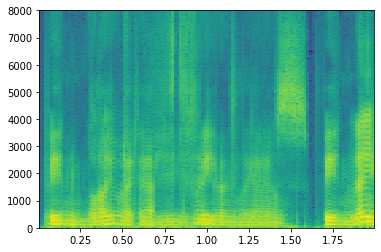

In [0]:
pred = pretrained_model.predict(ftr)
mean = np.loadtxt(os.path.normpath(os.path.join(write_path,'mean_mixed_log.txt')))
std = np.loadtxt(os.path.normpath(os.path.join(write_path,'std_mixed_log.txt')))
pred_unnorm = (pred*std)+mean
recon = reconstruct(pred_unnorm, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()



In [0]:
import soundfile as sf
# sf.write('D:\\studies\\university\\thesis\\speech_separation_codes\\du16\\donesomestuff\\results\\rbm\\1\\3layer_tanh_vis_nobias.wav',recon,16000)

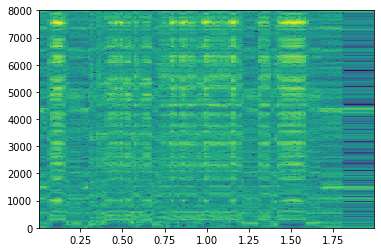

In [0]:
recon = reconstruct(hidden1_b, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)
Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

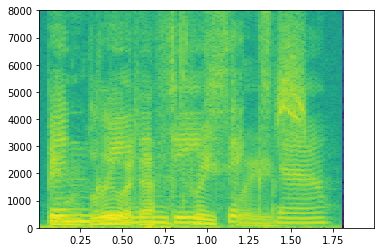

In [0]:
recon = reconstruct(ftr_raw, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)
from scipy import signal
# frequencies, times, spectrogram = signal.spectrogram(recon, 16000)
# plt.pcolormesh(times, frequencies, spectrogram)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.pcolormesh
# plt.show()
Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

In [0]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0]
len_data=d.shape
hh.close()
len_data

(771,)

In [0]:
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=256, win_length=512, window='hann')
    return recon

In [0]:
dataset

<PrefetchDataset shapes: ((?, 257), (?,)), types: (tf.float32, tf.float32)>